In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

In [80]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [81]:
# Load Data
company = 'EOS-USD'

start = dt.datetime(2012, 1, 1)
end = dt.datetime(2021, 1, 1)

data = web.DataReader(company, 'yahoo', start, end)

In [82]:
# Prepare Data

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
predictio_days = 60

X_train = []
y_train = []

for x in range(predictio_days, len(scaled_data)):
    X_train.append(scaled_data[x-predictio_days:x, 0])
    y_train.append(scaled_data[x, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) 

In [83]:
# Build The Model

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next close

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32)


Epoch 1/25
35/35 [==============================] - 6s 45ms/step - loss: 0.0106
Epoch 2/25
35/35 [==============================] - 2s 44ms/step - loss: 0.0045
Epoch 3/25
35/35 [==============================] - 1s 41ms/step - loss: 0.0037
Epoch 4/25
35/35 [==============================] - 1s 39ms/step - loss: 0.0034
Epoch 5/25
35/35 [==============================] - 1s 37ms/step - loss: 0.0032
Epoch 6/25
35/35 [==============================] - 1s 36ms/step - loss: 0.0029
Epoch 7/25
35/35 [==============================] - 1s 37ms/step - loss: 0.0032
Epoch 8/25
35/35 [==============================] - 1s 38ms/step - loss: 0.0024
Epoch 9/25
35/35 [==============================] - 1s 37ms/step - loss: 0.0026
Epoch 10/25
35/35 [==============================] - 1s 36ms/step - loss: 0.0019
Epoch 11/25
35/35 [==============================] - 1s 38ms/step - loss: 0.0022
Epoch 12/25
35/35 [==============================] - 1s 36ms/step - loss: 0.0025
Epoch 13/25
35/35 [==================

Test The Model Accuracy on Existing Data

In [84]:
# Load Test Data

test_start = dt.datetime(2021,1,1)
test_end= dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - predictio_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)


In [85]:
# Make Predictions on Test Data

x_test = []

for x in range(predictio_days, len(model_inputs)):
    x_test.append(model_inputs[x-predictio_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)

predicted_prices = scaler.inverse_transform(predicted_prices)

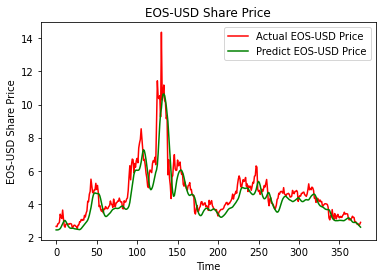

In [86]:
# Plot The Test Predictions

plt.plot(actual_prices, color="red", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predict {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

In [88]:
# Predict Next Day

real_data = [model_inputs[len(model_inputs) + 1 - predictio_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[2.5684545]]
